In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
from nolds import dfa, hurst_rs, mfhurst_b
import os
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu, pearsonr
from statsmodels.tsa.stattools import acf
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# cfg.params.low_pass = 0.1
# cfg.params.high_pass = 4

# cfg.params.low_pass = 80
# cfg.params.high_pass = 30

cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]


In [7]:
def get_ac_metrics(lfp_data, nlags=5000):
    ac50 = np.zeros(lfp_data.shape[1], dtype=int)
    integrated_ac50 = np.zeros(lfp_data.shape[1])
    ac0 = np.zeros(lfp_data.shape[1], dtype=int)
    integrated_ac0 = np.zeros(lfp_data.shape[1])
    integrated_upto_50ms = np.zeros(lfp_data.shape[1])

    dfa_vals = np.zeros(lfp_data.shape[1])
    hurst_rs_vals = np.zeros(lfp_data.shape[1])
    mfhurst_b_vals = np.zeros(lfp_data.shape[1])

    for i in range(lfp_data.shape[1]):
        acf_vals = acf(lfp_data[:, i], nlags=nlags)

        # ac50
        bool_mask = acf_vals < 0.5
        if np.any(bool_mask):
            ac50[i] = np.argmax(bool_mask)
        else:
            # print(f'No significant autocorrelation for electrode {electrodes_to_use[i]}')
            ac50[i] = nlags
        integrated_ac50[i] = np.trapezoid(acf_vals[:ac50[i] + 1], dx=1)

        #ac0
        bool_mask = acf_vals < 0.0
        if np.any(bool_mask):
            ac0[i] = np.argmax(bool_mask)
        else:
            # print(f'No significant autocorrelation for electrode {electrodes_to_use[i]}')
            ac0[i] = nlags
        integrated_ac0[i] = np.trapezoid(acf_vals[:ac0[i] + 1], dx=1)

        # dfa_vals[i] = dfa(lfp_data[:, i])
        hurst_rs_vals[i] = hurst_rs(lfp_data[:, i])
        mfhurst_b_vals[i] = mfhurst_b(lfp_data[:, i])[0]
    
    integrated_upto_50ms = np.trapezoid(acf_vals[:50], dx=1)

    return dict(
        ac50=ac50,
        integrated_ac50=integrated_ac50,
        ac0=ac0,
        integrated_ac0=integrated_ac0,
        integrated_upto_50ms=integrated_upto_50ms,
        dfa=dfa_vals,
        hurst_rs_vals=hurst_rs_vals,
        mfhurst_b_vals=mfhurst_b_vals,
    )

In [8]:
data_dir = os.path.join(os.path.dirname(cfg.plotting.img_save_dir), 'ac_metric_data')
os.makedirs(data_dir, exist_ok=True)

for data_class, agent in anesthetic_agent_list:
    agent_data_dir = os.path.join(data_dir, f"{agent}")
    os.makedirs(agent_data_dir, exist_ok=True)
    cfg.params.data_class = data_class
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        sessions_to_use = agent_data[(data_class, agent)]['session_lists'][monkey]['high']
        for session in sessions_to_use:
            file_path = os.path.join(agent_data_dir, f"{session}_ac_metrics.pkl")
            if os.path.exists(file_path):
                print(f"Skipping {session} because it already exists")
                continue
            df = agent_data[(data_class, agent)]['delase_results'][session]['all']

            if cfg.params.data_class == 'anesthesiaLvrOdd':
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, data_class, 'mat', f"{session}.mat"))
            else:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', data_class, f"{session}.mat"))

            lfp = TransposedDatasetView(session_file['lfp']).transpose()
            electrodes_to_use = np.setdiff1d(np.arange(lfp.shape[1]), agent_data[(data_class, agent)]['noise_filter_info'][session]['bad_electrodes'])
            dt = session_file['lfpSchema']['smpInterval'][0, 0]

            ac_metric_rows = []
            for i, row in tqdm(df.iterrows(), total=len(df)):
                window_lfp = lfp[int(row.window_start/dt):int(row.window_end/dt), electrodes_to_use]
                ac_metrics_dict = get_ac_metrics(window_lfp)
                ac_metrics_dict['window_start'] = row.window_start
                ac_metrics_dict['window_end'] = row.window_end
                ac_metric_rows.append(ac_metrics_dict)
            
            ac_metric_df = pd.DataFrame(ac_metric_rows)

            pd.to_pickle(ac_metric_df, file_path)

Skipping Mary-Anesthesia-20160818-02 because it already exists
Skipping Mary-Anesthesia-20160822-02 because it already exists
Skipping Mary-Anesthesia-20160809-01 because it already exists
Skipping Mary-Anesthesia-20160908-02 because it already exists
Skipping Mary-Anesthesia-20160902-02 because it already exists
Skipping Mary-Anesthesia-20160912-02 because it already exists
Skipping Mary-Anesthesia-20160916-02 because it already exists
Skipping Mary-Anesthesia-20160826-02 because it already exists
Skipping Mary-Anesthesia-20160914-02 because it already exists
Skipping Mary-Anesthesia-20160831-02 because it already exists
Skipping MrJones-Anesthesia-20160125-01 because it already exists
Skipping MrJones-Anesthesia-20160210-01 because it already exists
Skipping MrJones-Anesthesia-20160121-01 because it already exists
Skipping MrJones-Anesthesia-20160301-01 because it already exists
Skipping MrJones-Anesthesia-20160105-01 because it already exists
Skipping MrJones-Anesthesia-20160201-01 

In [9]:
def load_ac_metric_df(file_path):
    ac_metric_df = pd.read_pickle(file_path)
    keys = ['ac50', 'integrated_ac50', 'ac0', 'integrated_ac0', 'integrated_upto_50ms', 'hurst_rs_vals', 'mfhurst_b_vals']
    for key in keys:
        if isinstance(ac_metric_df[key].iloc[0], np.ndarray) and len(ac_metric_df[key].iloc[0]) > 1:
            ac_metric_df[key] = ac_metric_df[key].apply(lambda x: x.mean())
    return ac_metric_df

In [10]:
ac_metric_dfs = {}
for data_class, agent in anesthetic_agent_list:
    agent_data_dir = os.path.join(data_dir, f"{agent}")
    cfg.params.data_class = data_class
    ac_metric_dfs[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        sessions_to_use = agent_data[(data_class, agent)]['session_lists'][monkey]['high']
        ac_metric_dfs[(data_class, agent)][monkey] = {}
        for session in sessions_to_use:
            file_path = os.path.join(agent_data_dir, f"{session}_ac_metrics.pkl")
            if os.path.exists(file_path):
                # load the file
                ac_metric_dfs[(data_class, agent)][monkey][session] = load_ac_metric_df(file_path)

In [11]:
ac_metric_correl_means = {}
top_percent = 0.1
for data_class, agent in anesthetic_agent_list:
    ac_metric_correl_means[(data_class, agent)] = {}
    for monkey in ac_metric_dfs[(data_class, agent)]:
        ac_metric_correl_means[(data_class, agent)][monkey] = {'integrated_ac0': [], 'integrated_ac50': [], 'integrated_upto_50ms': [], 'ac0': [], 'ac50': [], 'hurst_rs_vals': [], 'mfhurst_b_vals': []}
        for session in ac_metric_dfs[(data_class, agent)][monkey]:
            df = agent_data[(data_class, agent)]['delase_results'][session]['all']
            ac_metric_df = ac_metric_dfs[(data_class, agent)][monkey][session]
            stab_curve = df.stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean())
            correls = {
                'integrated_ac0': pearsonr(ac_metric_df['integrated_ac0'], stab_curve).statistic,
                'integrated_ac50': pearsonr(ac_metric_df['integrated_ac50'], stab_curve).statistic,
                'integrated_upto_50ms': pearsonr(ac_metric_df['integrated_upto_50ms'], stab_curve).statistic,
                'ac0': pearsonr(ac_metric_df['ac0'], stab_curve).statistic,
                'ac50': pearsonr(ac_metric_df['ac50'], stab_curve).statistic,
                'hurst_rs_vals': pearsonr(ac_metric_df['hurst_rs_vals'], stab_curve).statistic,
                'mfhurst_b_vals': pearsonr(ac_metric_df['mfhurst_b_vals'], stab_curve).statistic,
            }
            for key in correls.keys():
                ac_metric_correl_means[(data_class, agent)][monkey][key].append(correls[key])


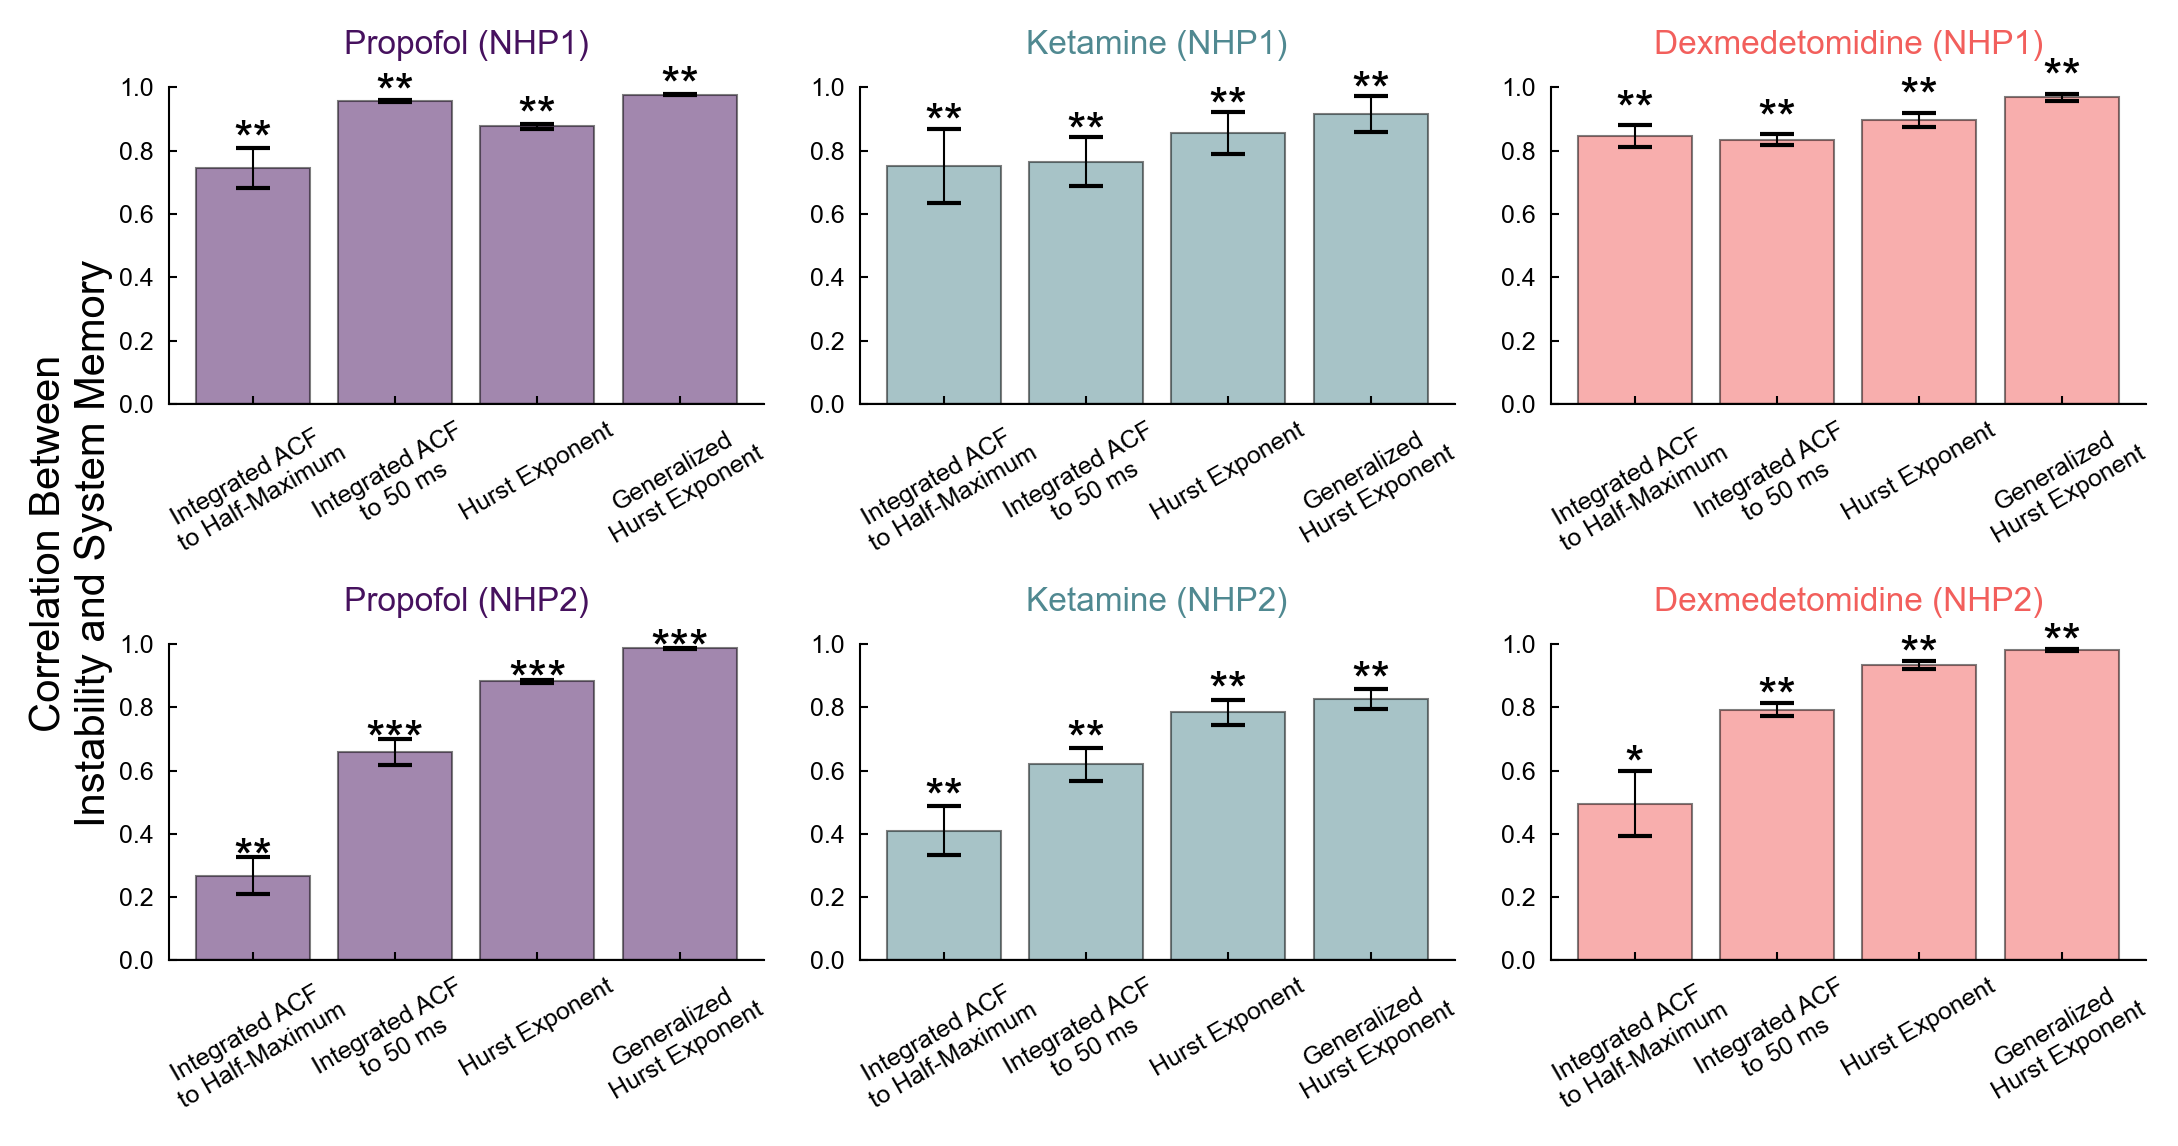

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Define metrics and consistent colors across subplots
metric_keys = [
    'integrated_ac50',
    'integrated_upto_50ms',
    'hurst_rs_vals',
    'mfhurst_b_vals',
]
metric_labels = ['Integrated ACF\n to Half-Maximum', 'Integrated ACF\n to 50 ms', 'Hurst Exponent', 'Generalized\nHurst Exponent']
# metric_colors = ['#4C78A8', '#F58518', '#54A24B', '#E45756']  # colorblind-friendly palette

# Define agent/monkey combinations and NHP labels
combos = [
    { 'key': ('propofolPuffTone', 'propofol'),       'agent': 'Propofol',        'monkey': 'Mary',     'nhp': 'NHP1' },
    { 'key': ('anesthesiaLvrOdd', 'ketamine'),       'agent': 'Ketamine',        'monkey': 'SPOCK',    'nhp': 'NHP1' },
    { 'key': ('anesthesiaLvrOdd', 'dexmedetomidine'),'agent': 'Dexmedetomidine', 'monkey': 'SPOCK',    'nhp': 'NHP1' },
    { 'key': ('propofolPuffTone', 'propofol'),       'agent': 'Propofol',        'monkey': 'MrJones',  'nhp': 'NHP2' },
    { 'key': ('anesthesiaLvrOdd', 'ketamine'),       'agent': 'Ketamine',        'monkey': 'PEDRI',    'nhp': 'NHP2' },
    { 'key': ('anesthesiaLvrOdd', 'dexmedetomidine'),'agent': 'Dexmedetomidine', 'monkey': 'PEDRI',    'nhp': 'NHP2' },
]

# Build the 2 x 3 plot
fig, axes = plt.subplots(2, 3, figsize=(7, 4))
for idx, combo in enumerate(combos):
    ax = axes[idx // 3, idx % 3]

    means, sems, pvals = [], [], []
    for mk in metric_keys:
        arr = np.asarray(ac_metric_correl_means[combo['key']][combo['monkey']][mk])
        arr = arr[~np.isnan(arr)] if arr.size else arr

        if arr.size:
            means.append(float(np.mean(arr)))
            sems.append(float(stats.sem(arr, ddof=1)) if arr.size > 1 else 0.0)
            # Wilcoxon signed-rank vs zero; handle edge cases safely
            p = np.nan
            try:
                if arr.size > 0:
                    p = stats.wilcoxon(arr, alternative='two-sided', zero_method='wilcox', correction=False).pvalue
            except Exception:
                p = np.nan
            pvals.append(p)
        else:
            means.append(np.nan)
            sems.append(0.0)
            pvals.append(np.nan)

    x = np.arange(len(metric_keys))
    # bars = ax.bar(x, means, yerr=sems, capsize=4, color=metric_colors, edgecolor='black', linewidth=0.5)
    bars = ax.bar(x, means, yerr=sems, capsize=4, color=cfg.plotting.curve_colors[combo['agent'].lower()], alpha=0.5, edgecolor='black', linewidth=0.5)

    # Determine y-limits with padding to ensure stars are visible
    with np.errstate(invalid='ignore'):
        y_max = np.nanmax(np.array(means) + np.array(sems)) if len(means) else 1.0
        y_min = np.nanmin(np.array(means) - np.array(sems)) if len(means) else -1.0
    if not np.isfinite(y_max):
        y_max = 1.0
    if not np.isfinite(y_min):
        y_min = -1.0
    if idx < 3:
        pad_scale = 0.2
    else:
        pad_scale = 0.11
    pad = pad_scale * (y_max - y_min if y_max > y_min else 1.0)
    # ax.set_ylim(y_min - pad * 0.2, y_max + pad)
    ax.set_ylim(0, 1)

    # Add significance stars above bars
    def p_to_stars(p):
        if not np.isfinite(p):
            return ''
        if p < 0.001:
            return '***'
        if p < 0.01:
            return '**'
        if p < 0.05:
            return '*'
        return ''

    for i, (b, m, s, p) in enumerate(zip(bars, means, sems, pvals)):
        stars = p_to_stars(p)
        if stars:
            top = (m if np.isfinite(m) else 0.0) + s
            ax.text(b.get_x() + b.get_width() / 2.0, top - pad, stars,
                    ha='center', va='bottom', fontsize=12, color='black')

    ax.axhline(0, color='k', linewidth=0.8, alpha=0.6)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels, rotation=30, ha='center')
    ax.set_title(f"{combo['agent']} ({combo['nhp']})", color=cfg.plotting.curve_colors[combo['agent'].lower()])

fig.text(-0.01, 0.5, 'Correlation Between\nInstability and System Memory', va='center', ha='center', rotation='vertical', fontsize=10)


# One legend, consistent colors for metrics across all subplots
# handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in metric_colors]
# fig.legend(handles, metric_labels, loc='upper center', ncol=4, frameon=False)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [12]:
print(f"Propofol, Mary, integrated_ac50: {np.mean(ac_metric_correl_means[('propofolPuffTone', 'propofol')]['Mary']['integrated_ac50'])}")
print(f"Propofol, Mary, integrated_upto_50ms: {np.mean(ac_metric_correl_means[('propofolPuffTone', 'propofol')]['Mary']['integrated_upto_50ms'])}")
print(f"Propofol, Mary, hurst_rs_vals: {np.mean(ac_metric_correl_means[('propofolPuffTone', 'propofol')]['Mary']['hurst_rs_vals'])}")
print(f"Propofol, Mary, mfhurst_b_vals: {np.mean(ac_metric_correl_means[('propofolPuffTone', 'propofol')]['Mary']['mfhurst_b_vals'])}")

print(f"Propofol, MrJones, integrated_ac50: {np.mean(ac_metric_correl_means[('propofolPuffTone', 'propofol')]['MrJones']['integrated_ac50'])}")
print(f"Propofol, MrJones, integrated_upto_50ms: {np.mean(ac_metric_correl_means[('propofolPuffTone', 'propofol')]['MrJones']['integrated_upto_50ms'])}")
print(f"Propofol, MrJones, hurst_rs_vals: {np.mean(ac_metric_correl_means[('propofolPuffTone', 'propofol')]['MrJones']['hurst_rs_vals'])}")
print(f"Propofol, MrJones, mfhurst_b_vals: {np.mean(ac_metric_correl_means[('propofolPuffTone', 'propofol')]['MrJones']['mfhurst_b_vals'])}")

print(f"Ketamine, SPOCK, integrated_ac50: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'ketamine')]['SPOCK']['integrated_ac50'])}")
print(f"Ketamine, SPOCK, integrated_upto_50ms: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'ketamine')]['SPOCK']['integrated_upto_50ms'])}")
print(f"Ketamine, SPOCK, hurst_rs_vals: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'ketamine')]['SPOCK']['hurst_rs_vals'])}")
print(f"Ketamine, SPOCK, mfhurst_b_vals: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'ketamine')]['SPOCK']['mfhurst_b_vals'])}")

print(f"Ketamine, PEDRI, integrated_ac50: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'ketamine')]['PEDRI']['integrated_ac50'])}")
print(f"Ketamine, PEDRI, integrated_upto_50ms: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'ketamine')]['PEDRI']['integrated_upto_50ms'])}")
print(f"Ketamine, PEDRI, hurst_rs_vals: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'ketamine')]['PEDRI']['hurst_rs_vals'])}")
print(f"Ketamine, PEDRI, mfhurst_b_vals: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'ketamine')]['PEDRI']['mfhurst_b_vals'])}")

print(f"Dexmedetomidine, SPOCK, integrated_ac50: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'dexmedetomidine')]['SPOCK']['integrated_ac50'])}")
print(f"Dexmedetomidine, SPOCK, integrated_upto_50ms: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'dexmedetomidine')]['SPOCK']['integrated_upto_50ms'])}")
print(f"Dexmedetomidine, SPOCK, hurst_rs_vals: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'dexmedetomidine')]['SPOCK']['hurst_rs_vals'])}")
print(f"Dexmedetomidine, SPOCK, mfhurst_b_vals: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'dexmedetomidine')]['SPOCK']['mfhurst_b_vals'])}")

print(f"Dexmedetomidine, PEDRI, integrated_ac50: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'dexmedetomidine')]['PEDRI']['integrated_ac50'])}")
print(f"Dexmedetomidine, PEDRI, integrated_upto_50ms: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'dexmedetomidine')]['PEDRI']['integrated_upto_50ms'])}")
print(f"Dexmedetomidine, PEDRI, hurst_rs_vals: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'dexmedetomidine')]['PEDRI']['hurst_rs_vals'])}")
print(f"Dexmedetomidine, PEDRI, mfhurst_b_vals: {np.mean(ac_metric_correl_means[('anesthesiaLvrOdd', 'dexmedetomidine')]['PEDRI']['mfhurst_b_vals'])}")

Propofol, Mary, integrated_ac50: 0.7454115984421965
Propofol, Mary, integrated_upto_50ms: 0.9565533903959432
Propofol, Mary, hurst_rs_vals: 0.8774709256931134
Propofol, Mary, mfhurst_b_vals: 0.9770354384503361
Propofol, MrJones, integrated_ac50: 0.2682910876815233
Propofol, MrJones, integrated_upto_50ms: 0.6581324972288888
Propofol, MrJones, hurst_rs_vals: 0.8815583386419396
Propofol, MrJones, mfhurst_b_vals: 0.9863284110876467
Ketamine, SPOCK, integrated_ac50: 0.7525287749028633
Ketamine, SPOCK, integrated_upto_50ms: 0.7655001638342414
Ketamine, SPOCK, hurst_rs_vals: 0.8566358450727448
Ketamine, SPOCK, mfhurst_b_vals: 0.9152485814880227
Ketamine, PEDRI, integrated_ac50: 0.41050616068626633
Ketamine, PEDRI, integrated_upto_50ms: 0.6199081011075388
Ketamine, PEDRI, hurst_rs_vals: 0.7843227419270901
Ketamine, PEDRI, mfhurst_b_vals: 0.826132959899699
Dexmedetomidine, SPOCK, integrated_ac50: 0.8454482161281729
Dexmedetomidine, SPOCK, integrated_upto_50ms: 0.8354056794476517
Dexmedetomidine